# Segmenting an Ecommerce website Customer Base

Last updated : October 6th, 2022

## Introduction

During this project, I will use a dataset provided by a Brazilian Ecommerce website to segment its customer base using unsupervised machine learning models. 

In [1]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

#Importing Intel extension for sklearn to improve speed
# from sklearnex import patch_sklearn
# patch_sklearn()

## 1. Preprocessing

### 1.1 Loading the datasets

In [2]:
orders = pd.read_csv("Data/olist_orders_dataset.csv")
order_items = pd.read_csv("Data/olist_order_items_dataset.csv")
order_payments = pd.read_csv("Data/olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("Data/olist_order_reviews_dataset.csv")
products = pd.read_csv("Data/olist_products_dataset.csv")
sellers = pd.read_csv("Data/olist_sellers_dataset.csv")
customers = pd.read_csv("Data/olist_customers_dataset.csv")
locations = pd.read_csv("Data/olist_geolocation_dataset.csv")
category_translation = pd.read_csv("Data/product_category_name_translation.csv")

order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### 1.2 Cleaning and translating category names

In [3]:
#Importing the itertools combinations function that will generate unique pairs of our list
from itertools import combinations
#Importing Levenshtein, an algorithm that calculates the distance between the strings
from Levenshtein import distance as levenshtein_distance

#Defining our distance function
def calculate_lev_dist(x):
    return levenshtein_distance(x['first'],x['second'])

#Defining the function that will iterate over the specified indexes of our dataframe and create
#A list of dataframes containing all the pairs ordered by Levenshtein distance (ascending)
def check_similarities(df: pd.DataFrame, index):
    i = 0
    dataframes = []
    for c in df.columns:
        names = []
        if np.isin(i, index):
            #Creating a list of unique names
            name_list = df[c].dropna().unique()
            #Creating an empty array
            names = []
            #Iterating over all pairs of our list
            for c in combinations(name_list,2):
                #Appending a dictionary to the list with the 2 elements
                names.append({'first': c[0], 'second': c[1]})
            #Creating a names_df dataframe
            names_df = pd.DataFrame(names)
            #Calculating the levenshtein distance for each value pairs
            names_df['lev_dist'] = names_df.apply(calculate_lev_dist, axis=1)
            #Sorting the dataframe by levenshtein distance
            names_df.sort_values(by='lev_dist', inplace=True)
            #Adding our names_df to our list of dataframes (called 'dataframes')
            dataframes.append(names_df)
        i += 1
    return dataframes

check_similarities(products, [1])[0]

products.loc[products.product_category_name == 'eletrodomesticos_2', 'product_category_name'] = "eletrodomesticos"
products.loc[products.product_category_name == 'casa_conforto_2', 'product_category_name'] = "casa_conforto"
products.loc[products.product_category_name == 'pc_gamer', 'product_category_name'] = "pcs"

products.product_category_name.value_counts()

cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
moveis_colchao_e_estofado          10
tablets_impressao_imagem            9
fashion_roupa_infanto_juvenil       5
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: product_category_name, Length: 70, dtype: int64

In [4]:
#Figuring out if all translated names are in the translation
[x for x in products.product_category_name.unique() if not np.isin(x, category_translation.product_category_name.unique())]

[nan, 'portateis_cozinha_e_preparadores_de_alimentos']

In [5]:
#Manually adding not translated category
category_translation = category_translation.append({'product_category_name': 'portateis_cozinha_e_preparadores_de_alimentos',
                             'product_category_name_english': 'kitchen_and_food_preparation_appliances'}, ignore_index=True)

products = pd.merge(products, category_translation, on='product_category_name', how='inner')

products.drop(columns={'product_category_name'}, inplace=True)
products.rename(columns={'product_category_name_english': 'product_category_name'}, inplace=True)
products.head()


C:\Users\Faskill\AppData\Local\Temp\ipykernel_3076\414929226.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  category_translation = category_translation.append({'product_category_name': 'portateis_cozinha_e_preparadores_de_alimentos',


,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


### 1.3 Merging the order items and products dataframes

In [6]:
#Inner join because we will eventually drop the products that have no info
order_products = pd.merge(order_items, products, on='product_id', how='inner')
#Dropping the product name and description length that will not be relevant
order_products = order_products.drop(columns={"product_name_lenght","product_description_lenght","product_id"})
#We also remove product_id since we have already gathered all the data from the product_id table
order_products.head()

,order_id,order_item_id,seller_id,shipping_limit_date,price,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,130898c0987d1801452a8ed92a670612,1,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,4.0,650.0,28.0,9.0,14.0,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,1,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4.0,650.0,28.0,9.0,14.0,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,1,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,4.0,650.0,28.0,9.0,14.0,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,1,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,4.0,650.0,28.0,9.0,14.0,cool_stuff


### 1.4 Data imputation of missing coordinates and merging with sellers

In [9]:
#Several locations for each zip_code_prefix
locations.groupby(["geolocation_zip_code_prefix","geolocation_city","geolocation_state"]).nunique()

#We will average them to have a mean location for each zip_code to prepare the merge with our sellers dataframe

locations_zip = locations[["geolocation_zip_code_prefix",
                       "geolocation_lat", "geolocation_lng"]].groupby("geolocation_zip_code_prefix").mean().reset_index()

locations_zip

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733
...,...,...,...
19010,99960,-27.953722,-52.025511
19011,99965,-28.183372,-52.039850
19012,99970,-28.343766,-51.874689
19013,99980,-28.389129,-51.843836


In [10]:
sellers = pd.merge(sellers.drop(columns={"seller_city"}), locations_zip, how="left",
                   left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix")

sellers.drop(columns={"geolocation_zip_code_prefix"}, inplace=True)
sellers.rename(columns={"geolocation_lat": "seller_lat", "geolocation_lng": "seller_long"},inplace=True)

sellers.head()

,seller_id,seller_zip_code_prefix,seller_state,seller_lat,seller_long
0,3442f8959a84dea7ee197c632cb2df15,13023,SP,-22.893848,-47.061337
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,SP,-22.383437,-46.947927
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,RJ,-22.909572,-43.177703
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,SP,-23.657242,-46.612831
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,SP,-22.964803,-46.534419


In [11]:
sellers[sellers.seller_lat.isna()]
#8 sellers without geolocation

#Averaging the location of all states to gather data from sellers with no matching zip code
locations_state = locations[["geolocation_state",
                       "geolocation_lat", "geolocation_lng"]].groupby("geolocation_state").mean().reset_index()

missing_loc_sellers = pd.merge(sellers[sellers.seller_lat.isna()].drop(columns={"seller_lat","seller_long"}),
                               locations_state, how="left", left_on="seller_state", right_on="geolocation_state")

missing_loc_sellers.drop(columns={"geolocation_state"}, inplace=True)
missing_loc_sellers.rename(columns={"geolocation_lat": "seller_lat", "geolocation_lng": "seller_long"},inplace=True)

missing_loc_sellers

,seller_id,seller_zip_code_prefix,seller_state,seller_lat,seller_long
0,5962468f885ea01a1b6a97a218797b0a,82040,PR,-24.793607,-50.879662
1,2aafae69bf4c41fbd94053d9413e87ee,91901,RS,-29.679191,-52.032652
2,2a50b7ee5aebecc6fd0ff9784a4747d6,72580,DF,-15.810885,-47.969630
3,2e90cb1677d35cfe24eef47d441b7c87,2285,SP,-23.155308,-47.084074
4,0b3f27369a4d8df98f7eb91077e438ac,7412,SP,-23.155308,-47.084074
5,42bde9fef835393bb8a8849cb6b7f245,71551,DF,-15.810885,-47.969630
6,870d0118f7a9d85960f29ad89d5d989a,37708,MG,-19.864647,-44.421615


In [12]:
sellers = sellers[sellers.seller_lat.notna()]

sellers = pd.concat([sellers, missing_loc_sellers])

sellers[sellers.seller_lat.isna()]
#No missing coordinate

,seller_id,seller_zip_code_prefix,seller_state,seller_lat,seller_long


### 1.5 Merging sellers, orders and order products

In [13]:
#Mergin seller info back into our order_products dataframe

order_products = pd.merge(order_products, sellers, how="left", on="seller_id" )

order_products[order_products.seller_lat.isna()]
#All items were merged

order_products.drop(columns={"seller_id"}, inplace=True)

order_products.duplicated().any()
#No duplicates

order_products

,order_id,order_item_id,shipping_limit_date,price,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name,seller_zip_code_prefix,seller_state,seller_lat,seller_long
0,00010242fe8c5a6d1ba2dd792cb16214,1,2017-09-19 09:45:35,58.9,13.29,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277,SP,-22.496953,-44.127492
1,130898c0987d1801452a8ed92a670612,1,2017-07-05 02:44:11,55.9,17.96,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277,SP,-22.496953,-44.127492
2,532ed5e14e24ae1f0d735b91524b98b9,1,2018-05-23 10:56:25,64.9,18.33,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277,SP,-22.496953,-44.127492
3,6f8c31653edb8c83e1a739408b5ff750,1,2017-08-07 18:55:08,58.9,16.17,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277,SP,-22.496953,-44.127492
4,7d19f4ef4d04461989632411b7e588b9,1,2017-08-16 22:05:11,58.9,13.29,4.0,650.0,28.0,9.0,14.0,cool_stuff,27277,SP,-22.496953,-44.127492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111042,ffebd80e3291e811c308365936897efd,1,2018-07-18 20:23:55,129.9,51.20,1.0,6700.0,35.0,12.0,22.0,garden_tools,99730,RS,-27.728956,-52.536535
111043,ffee31fb4b5e35c9123608015637c495,1,2018-08-21 10:10:11,99.0,13.52,1.0,2300.0,37.0,30.0,20.0,furniture_decor,80330,PR,-25.469974,-49.307372
111044,fff7c4452f050315db1b3f24d9df5fcd,1,2017-06-07 17:05:23,736.0,20.91,3.0,400.0,19.0,9.0,15.0,watches_gifts,6429,SP,-23.489688,-46.952915
111045,fffa82886406ccf10c7b4e35c4ff2788,1,2017-12-22 17:31:42,229.9,44.02,2.0,2700.0,60.0,15.0,15.0,sports_leisure,5141,SP,-23.492024,-46.728984


In [14]:
#Order ids without product are discarded, we do an inner join here
orders = pd.merge(orders, order_products, how="inner", on="order_id")

orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name,seller_zip_code_prefix,seller_state,seller_lat,seller_long
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,2017-10-06 11:07:15,...,4.0,500.0,19.0,8.0,13.0,housewares,9350,SP,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,2018-07-30 03:24:27,...,1.0,400.0,19.0,13.0,19.0,perfumery,31570,SP,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,2018-08-13 08:55:23,...,1.0,420.0,24.0,19.0,21.0,auto,14840,SP,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,2017-11-23 19:45:59,...,3.0,450.0,30.0,10.0,20.0,pet_shop,31842,MG,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,2018-02-19 20:31:37,...,4.0,250.0,51.0,15.0,15.0,stationery,8752,SP,-23.543395,-46.262086


In [15]:
order_payments.head()

print(order_payments.order_id.nunique(), len(order_payments))


99440 103886


### 1.6 Data imputation of missing coordinates and cleanup of customers dataframe

In [17]:
print(customers.customer_unique_id.nunique(), customers.customer_id.nunique(), len(customers))
#We have some returning customers in our database, tracked by customer_unique_id

customer_count=customers[["customer_id","customer_unique_id"]].groupby("customer_unique_id").count().reset_index().sort_values(
    by="customer_id", ascending=False)
#At most we have a customer unique_id with 17 different customer ids

customer_count["customer_id"].value_counts(normalize=True)
#97% of customers have a single customer ID

96096 99441 99441


1     0.968812
2     0.028565
3     0.002112
4     0.000312
5     0.000083
6     0.000062
7     0.000031
17    0.000010
9     0.000010
Name: customer_id, dtype: float64

In [18]:
customers = pd.merge(customers, locations_zip, how="left",
                     left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix")

print(customers[customers.geolocation_lat.isna()])
customers.head()

                            customer_id                customer_unique_id  \
354    ecb1725b26e8b8c458181455dfa434ea  b55a113bb84fc10eaf58c6d09ec69794   
382    bcf86029aeed4ed8bac0e16eb14c22f5  7cd7974c9f79f75b77f323878ef87f43   
877    f4302056f0c58570522590f8181de2c7  67b05b597a66b5c449025000b9430abb   
1218   03bbe0ce5c28e05f22917607db798818  8f3dca4306d5a89e4ae2c65c110603a2   
1272   ad4950aded55c2ea376be59506456d68  aa2b96dd03307ea6dc4b763c0b5f0b39   
...                                 ...                               ...   
97467  cf818420383856a129134f5f8343f7b8  795c495a65f983b242fb01bd507977c5   
97780  67f3e907dce402e696b15f9308ff22ed  6f232f2f5c7f33b7bd9d794d2afacadd   
98140  f792e419335df11d82c32efcfb09c51b  c04c085b8e7573ba87b9ae1968d0985e   
98878  78a11bb1fa72f556996b9a5b9bcd0629  e7536f62a200b415edd9491ac12a17fa   
99264  ff09fd7b29e7488a8d8a20badcd8befe  8c21dd8c37144807c601f99f2a209dfb   

       customer_zip_code_prefix             customer_city customer_state  \

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.498489,-47.396929
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,9790.0,-23.727992,-46.542848
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1151.0,-23.531642,-46.656289
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,8775.0,-23.499702,-46.185233
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,13056.0,-22.975100,-47.142925


In [19]:
#As with sellers, we replace the missing geocordinate data by the mean data by state
missing_cust_geo = pd.merge(customers[customers.geolocation_lat.isna()].drop(columns={"geolocation_lat","geolocation_lng"}),
                            locations_state, how="left", left_on="customer_state", right_on="geolocation_state")

print(missing_cust_geo[missing_cust_geo.geolocation_lat.isna()])
#No more missing geocordinates

missing_cust_geo.drop(columns={"geolocation_zip_code_prefix","geolocation_state"}, inplace=True)
missing_cust_geo.head()

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state, geolocation_zip_code_prefix, geolocation_state, geolocation_lat, geolocation_lng]
Index: []


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,ecb1725b26e8b8c458181455dfa434ea,b55a113bb84fc10eaf58c6d09ec69794,72300,brasilia,DF,-15.810885,-47.969630
1,bcf86029aeed4ed8bac0e16eb14c22f5,7cd7974c9f79f75b77f323878ef87f43,11547,cubatao,SP,-23.155308,-47.084074
2,f4302056f0c58570522590f8181de2c7,67b05b597a66b5c449025000b9430abb,64605,picos,PI,-5.754989,-42.509541
3,03bbe0ce5c28e05f22917607db798818,8f3dca4306d5a89e4ae2c65c110603a2,72465,brasilia,DF,-15.810885,-47.969630
4,ad4950aded55c2ea376be59506456d68,aa2b96dd03307ea6dc4b763c0b5f0b39,7729,caieiras,SP,-23.155308,-47.084074


In [20]:
customers = customers[customers.geolocation_lat.notna()]

customers = pd.concat([customers, missing_cust_geo], ignore_index=True)

customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,14409.0,-20.498489,-47.396929
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,9790.0,-23.727992,-46.542848
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1151.0,-23.531642,-46.656289
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,8775.0,-23.499702,-46.185233
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,13056.0,-22.975100,-47.142925


In [21]:
customers.drop(columns={"geolocation_zip_code_prefix"}, inplace=True)
customers.rename(columns={"geolocation_lat": "customer_lat", "geolocation_lng": "customer_long"}, inplace=True)

customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925


### 1.7 Merging all remaining dataframes

In [22]:
#Inner merge since we want to study orders and are only interested in orders with customer information
df = pd.merge(customers, orders, how="inner", on="customer_id")

#We can now drop customer_id since we will use the unique_id for the remainder of the project
df.drop(columns={"customer_id"}, inplace=True)

print(len(df.customer_unique_id.unique()), len(df.order_id.unique()), len(df))

94108 97277 111047


In [23]:
order_reviews.head()

order_reviews[order_reviews["order_id"].duplicated()]
#Some orders have different review

order_reviews["review_creation_date"] = pd.to_datetime(order_reviews["review_creation_date"])

#Aggregating by order id, averaging review score and review date and couting the number of columns and messages/titles
order_reviews = order_reviews.groupby("order_id").agg(
    review_score = ('review_score' , 'mean'), review_date = ('review_creation_date', 'mean'),
    review_ncomments = ('review_comment_message','count'), review_ntitle = ('review_comment_title', 'count'),
    n_reviews = ('review_id', 'nunique')).reset_index()

order_reviews.head()

,order_id,review_score,review_date,review_ncomments,review_ntitle,n_reviews
0,00010242fe8c5a6d1ba2dd792cb16214,5.0,2017-09-21,1,0,1
1,00018f77f2f0320c557190d7a144bdd3,4.0,2017-05-13,0,0,1
2,000229ec398224ef6ca0657da4fc703e,5.0,2018-01-23,1,0,1
3,00024acbcdf0a6daa1e931b038114c75,4.0,2018-08-15,0,0,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0,2017-03-02,1,0,1


In [24]:
df = pd.merge(df, order_reviews, how="left", on="order_id")

df.head()

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,order_id,order_status,order_purchase_timestamp,order_approved_at,...,product_category_name,seller_zip_code_prefix,seller_state,seller_lat,seller_long,review_score,review_date,review_ncomments,review_ntitle,n_reviews
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,office_furniture,8577,SP,-23.486111,-46.366721,4.0,2017-05-26,0.0,0.0,1.0
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,...,housewares,88303,SC,-26.912574,-48.673980,5.0,2018-01-30,0.0,0.0,1.0
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,...,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-06-15,0.0,0.0,1.0
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,...,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-03-29,0.0,0.0,1.0
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,...,home_confort,14940,SP,-21.757321,-48.829744,5.0,2018-08-10,1.0,1.0,1.0


In [25]:
order_payments["order_id"].duplicated().any()
#Some duplicate orders in this dataset

order_payments.head()

order_payments_type = pd.crosstab(index=order_payments["order_id"], columns=order_payments["payment_type"])

order_payments_type

payment_type,boleto,credit_card,debit_card,not_defined,voucher
order_id,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0,1,0,0,0
00018f77f2f0320c557190d7a144bdd3,0,1,0,0,0
000229ec398224ef6ca0657da4fc703e,0,1,0,0,0
00024acbcdf0a6daa1e931b038114c75,0,1,0,0,0
00042b26cf59d7ce69dfabb4e55b4fd9,0,1,0,0,0
...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1,0,0,0,0
fffcd46ef2263f404302a634eb57f7eb,1,0,0,0,0
fffce4705a9662cd70adb13d4a31832d,0,1,0,0,0


In [26]:
order_payments_agg = order_payments.groupby("order_id").agg(
    payment_sequential = ('payment_sequential', 'mean'), payment_installments = ('payment_installments', 'sum'),
    payment_value = ('payment_value', 'sum')).reset_index()

#Flagging order with sequential payments
order_payments_agg["payment_sequential_flag"] = 0
order_payments_agg.loc[order_payments_agg.payment_sequential > 1] = 1

order_payments_agg.head()

,order_id,payment_sequential,payment_installments,payment_value,payment_sequential_flag
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,2,72.19,0
1,00018f77f2f0320c557190d7a144bdd3,1.0,3,259.83,0
2,000229ec398224ef6ca0657da4fc703e,1.0,5,216.87,0
3,00024acbcdf0a6daa1e931b038114c75,1.0,2,25.78,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,3,218.04,0


In [27]:
payments = pd.merge(order_payments_agg, order_payments_type, how="inner", on="order_id")

df = pd.merge(df, payments, how="left", on="order_id")

df

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,order_id,order_status,order_purchase_timestamp,order_approved_at,...,n_reviews,payment_sequential,payment_installments,payment_value,payment_sequential_flag,boleto,credit_card,debit_card,not_defined,voucher
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,1.0,1.0,2.0,146.87,0.0,0.0,1.0,0.0,0.0,0.0
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,...,1.0,1.0,8.0,335.48,0.0,0.0,1.0,0.0,0.0,0.0
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,...,1.0,1.0,7.0,157.73,0.0,0.0,1.0,0.0,0.0,0.0
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,...,1.0,1.0,1.0,173.30,0.0,0.0,1.0,0.0,0.0,0.0
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,...,1.0,1.0,8.0,252.25,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111042,795c495a65f983b242fb01bd507977c5,72338,brasilia,DF,-15.810885,-47.969630,e13f9d9f79f8325d4f77d26e7384e9fd,delivered,2017-07-11 18:23:43,2017-07-13 03:04:39,...,1.0,1.0,1.0,59.00,0.0,1.0,0.0,0.0,0.0,0.0
111043,6f232f2f5c7f33b7bd9d794d2afacadd,68629,paragominas,PA,-2.631213,-49.485862,e2f630b53cb2637be372c3810b089868,shipped,2017-07-26 11:44:28,2017-07-27 11:25:25,...,1.0,1.0,1.0,175.32,0.0,1.0,0.0,0.0,0.0,0.0
111044,c04c085b8e7573ba87b9ae1968d0985e,28530,sao sebastiao do paraiba,RJ,-22.743477,-43.155540,84a80b02b3af075990fc7d9d2369f066,delivered,2017-10-15 19:33:54,2017-10-18 08:35:17,...,1.0,1.0,5.0,571.16,0.0,0.0,1.0,0.0,0.0,0.0
111045,e7536f62a200b415edd9491ac12a17fa,55863,siriji,PE,-8.179098,-35.758866,19b6861ce084842fb4ec0cafc59deebe,delivered,2018-05-15 13:01:12,2018-05-15 13:30:44,...,1.0,1.0,7.0,77.03,0.0,0.0,1.0,0.0,0.0,0.0


### 1.8 Feature filtering and NA removal

In [28]:
#Dropping columns with no order_id
df = df[df.order_id.notna()]

print(df.order_status.unique())

#Keeping only completed or cancelled orders
df = df[(df.order_status=="delivered") | (df.order_status=="canceled")]

df[df.payment_value.isna()]

['delivered' 'invoiced' 'shipped' 'processing' 'canceled' 'unavailable'
 'approved']


,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,order_id,order_status,order_purchase_timestamp,order_approved_at,...,n_reviews,payment_sequential,payment_installments,payment_value,payment_sequential_flag,boleto,credit_card,debit_card,not_defined,voucher
17,7f3a72e8f988c6e735ba118d54f47458,5416,sao paulo,SP,-23.560949,-46.688422,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,ef07ba9aa5226f77264ffa5762b2280b,81750,curitiba,PR,-25.517959,-49.241322,a9119eb77d6200811953803a7b6539e1,delivered,2018-03-12 13:07:03,2018-03-12 13:15:28,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,d85547cd859833520b311b4458a14c1c,23970,parati,RJ,-23.212886,-44.707780,a6917b5d71e0e9bc434e9228db8daeb2,delivered,2017-06-09 15:46:17,2017-06-10 15:42:38,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,b3548d0cec408ae13d143bb4eeebaa6c,13323,salto,SP,-23.216315,-47.271594,db97652cf517d2cd03db63dec489ca62,delivered,2017-10-01 08:57:03,2017-10-01 09:14:07,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,6edd17d0a29e2d4057e694afee5eaa3b,28010,campos dos goytacazes,RJ,-21.761750,-41.322672,9cefab6270eb935eb96a97c56b8e7984,delivered,2018-06-07 21:41:19,2018-06-07 21:54:43,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110906,b21420e415588331cf9797592a3d9456,72238,brasilia,DF,-15.810885,-47.969630,2153e9009ecf443d84e5f48861fb7094,delivered,2017-12-06 16:02:30,2017-12-08 19:35:22,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110953,56f8e0d601a82ef7d2f05589daacd600,94370,ipiranga,RS,-29.679191,-52.032652,7e8072dc0f35ebb0c1b2a4743e0f179a,delivered,2018-06-27 14:07:03,2018-06-28 20:10:14,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110975,0e2a10c8d1b35dca12057704d738bdb6,7412,aruja,SP,-23.155308,-47.084074,dddc545a77663ef26d16778d03ef3bcd,delivered,2018-02-06 11:34:34,2018-02-06 11:49:49,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111010,e68be0a3138a025690efbc7275b629e8,86996,sao miguel do cambui,PR,-24.793607,-50.879662,1e54e64066c85e4c0b929c0dde6bec3b,delivered,2018-02-01 19:56:10,2018-02-01 20:13:56,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
#Percentage of rows with missing values
print(df.isna().any(axis=1).sum()/len(df))
#Only 4.2%
print(len(df))

#Dropping fields with nas
df = df.dropna()

print(len(df))

df.head()

0.042010111001208925
109188
104601


,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,order_id,order_status,order_purchase_timestamp,order_approved_at,...,n_reviews,payment_sequential,payment_installments,payment_value,payment_sequential_flag,boleto,credit_card,debit_card,not_defined,voucher
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,...,1.0,1.0,2.0,146.87,0.0,0.0,1.0,0.0,0.0,0.0
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,...,1.0,1.0,8.0,335.48,0.0,0.0,1.0,0.0,0.0,0.0
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,...,1.0,1.0,7.0,157.73,0.0,0.0,1.0,0.0,0.0,0.0
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,...,1.0,1.0,1.0,173.30,0.0,0.0,1.0,0.0,0.0,0.0
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,...,1.0,1.0,8.0,252.25,0.0,0.0,1.0,0.0,0.0,0.0


In [30]:
pd.options.display.max_columns = 100
df.head()

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,freight_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name,seller_zip_code_prefix,seller_state,seller_lat,seller_long,review_score,review_date,review_ncomments,review_ntitle,n_reviews,payment_sequential,payment_installments,payment_value,payment_sequential_flag,boleto,credit_card,debit_card,not_defined,voucher
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,2017-05-22 15:22:12,124.99,21.88,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,SP,-23.486111,-46.366721,4.0,2017-05-26,0.0,0.0,1.0,1.0,2.0,146.87,0.0,0.0,1.0,0.0,0.0,0.0
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,2018-01-18 20:58:32,289.00,46.48,3.0,10150.0,89.0,15.0,40.0,housewares,88303,SC,-26.912574,-48.673980,5.0,2018-01-30,0.0,0.0,1.0,1.0,8.0,335.48,0.0,0.0,1.0,0.0,0.0,0.0
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,2018-06-05 16:19:10,139.94,17.79,1.0,8267.0,52.0,52.0,17.0,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-06-15,0.0,0.0,1.0,1.0,7.0,157.73,0.0,0.0,1.0,0.0,0.0,0.0
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,2018-03-27 16:31:16,149.94,23.36,1.0,12160.0,56.0,51.0,28.0,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-03-29,0.0,0.0,1.0,1.0,1.0,173.30,0.0,0.0,1.0,0.0,0.0,0.0
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,2018-07-31 10:10:09,230.00,22.25,1.0,5200.0,45.0,15.0,35.0,home_confort,14940,SP,-21.757321,-48.829744,5.0,2018-08-10,1.0,1.0,1.0,1.0,8.0,252.25,0.0,0.0,1.0,0.0,0.0,0.0


In [31]:
#Removing product weight, height and length information :
df.drop(columns={"product_weight_g","product_length_cm","product_height_cm","product_width_cm"},inplace=True)

#Turning the datetime columns into datetime
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
df["order_approved_at"] = pd.to_datetime(df["order_approved_at"])
df["order_delivered_customer_date"] = pd.to_datetime(df["order_delivered_customer_date"])
df["order_estimated_delivery_date"] = pd.to_datetime(df["order_estimated_delivery_date"])
df["shipping_limit_date"] = pd.to_datetime(df["shipping_limit_date"])

We have now completed preprocessing, and will continue by performing an **Exploratory Data Analysis** of our dataset.

## 2. Exploratory Data Analysis

We will first analyse the structure of our dataset.

### 2.1 Structure analysis

In [32]:
#Checking for outliers

print(df["order_purchase_timestamp"].max(), df["order_purchase_timestamp"].min())
#Data from October 2016 to August 2018 (23 months)

df.describe()

2018-08-29 15:00:37 2016-10-03 09:44:50


,customer_zip_code_prefix,customer_lat,customer_long,order_item_id,price,freight_value,product_photos_qty,seller_zip_code_prefix,seller_lat,seller_long,review_score,review_ncomments,review_ntitle,n_reviews,payment_sequential,payment_installments,payment_value,payment_sequential_flag,boleto,credit_card,debit_card,not_defined,voucher
count,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.000000,104601.0,104601.000000,104601.000000,104601.0,104601.000000,104601.000000,104601.000000,104601.0,104601.000000
mean,35134.118584,-21.255868,-46.234729,1.197551,119.823533,19.954127,2.210380,24558.623283,-22.791640,-47.248396,4.084771,0.421459,0.121366,1.005918,1.0,3.038403,179.255839,0.0,0.209166,0.765012,0.014981,0.0,0.010841
std,29936.676973,5.544591,4.024424,0.697262,179.829678,15.726098,1.722532,27705.306559,2.714594,2.346642,1.344000,0.496864,0.326992,0.077443,0.0,2.806137,270.405112,0.0,0.406715,0.423993,0.121476,0.0,0.103556
min,1003.000000,-33.689948,-72.668881,1.000000,0.850000,0.000000,1.000000,1001.000000,-32.079231,-63.893565,1.000000,0.000000,0.000000,1.000000,1.0,1.000000,10.070000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,11089.000000,-23.592896,-48.125102,1.000000,39.900000,13.080000,1.000000,6429.000000,-23.609430,-48.829744,4.000000,0.000000,0.000000,1.000000,1.0,1.000000,65.710000,0.0,0.000000,1.000000,0.000000,0.0,0.000000
50%,24240.000000,-22.930175,-46.636773,1.000000,74.900000,16.270000,1.000000,13660.000000,-23.418614,-46.755753,5.000000,0.000000,0.000000,1.000000,1.0,2.000000,114.330000,0.0,0.000000,1.000000,0.000000,0.0,0.000000
75%,59069.000000,-20.179524,-43.705683,1.000000,134.900000,21.150000,3.000000,28615.000000,-21.757321,-46.522287,5.000000,1.000000,0.000000,1.000000,1.0,4.000000,195.420000,0.0,0.000000,1.000000,0.000000,0.0,0.000000
max,99980.000000,42.184003,-8.723762,21.000000,6735.000000,409.680000,20.000000,99730.000000,-2.501242,-34.855616,5.000000,3.000000,2.000000,3.000000,1.0,24.000000,13664.080000,0.0,1.000000,1.000000,1.000000,0.0,1.000000


In [33]:
#Shape of the dataset and count of value types
print(df.shape)
print(pd.value_counts(df.dtypes))

(104601, 37)
float64           20
object             8
datetime64[ns]     6
int64              3
dtype: int64


As we have seen, we have **104k samples and 37 features, with 8 categorical features, 6 datetime features and 23 numeric features**. No outliers have been identified at this point.

### 2.2 Repartition of Categorical features

We will now look a bit more in detail at categorical features and particularly at their repartition using pie and bar charts.

In [34]:
# #Importing plotly packages
# import plotly.express as px
# import plotly.graph_objects as go

# def category_analysis(df: pd.DataFrame, labels={}):
#     if len(labels) == 0:
#         labels = {}
#         for c in df.columns:
#             labels[c] = c
#     for c in df.columns:
#         #Filtering and selecting only categorical variables
#         if df[c].dtype == 'object':
#             #Filtering only categorical fields (with less than 100 different values)
#             if len(df[c].unique()) < 100:
#                 #Creating a Series with the percentage of each values
#                 subset = df[c].value_counts(normalize=True).sort_index()
#                 #Replacing values < 2% by an "Other" category aggregation
#                 for s in subset:
#                     if s < 0.02:
#                         label = subset[subset==s].index[0]
#                         subset.drop(labels=[label],inplace=True)

#                 other_count = 1 - subset.sum()
#                 if other_count != 0:
#                     subset["Other"] = other_count
#                 #Filtering variables with less than 20 categories after "Other aggregation" to plot pie chart
#                 if len(subset) <= 20: 
#                     #Creating pie chart
#                     sub = pd.DataFrame(subset)
#                     sub[c] = round(sub[c],3)
#                     fig = go.Figure(data=[go.Pie(values=sub[c], labels=sub.index)])
#                     fig.update_layout(
#                     title={
#                         'text': "Pie chart of the repartition of {}".format(labels[c]),
#                     },
#                     title_x = 0.5,
#                     font=dict(
#                         size=18,
#                         color="Black"
#                     ))
#                     fig.show()
#                 #For categories between 20 and 100 categories, we will plot the top 5 most frequent categories
#                 else: 
#                     #Grouping by the variable chosen and counting the values, we use domain as our count variable since it is complete
#                     top_5 = df[[c]].groupby(c).agg(count = (c, 'count')).reset_index().sort_values(by='count', ascending=False)
#                     #Calculating percentage
#                     n = len(df)
#                     top_5["pct"] = round(top_5["count"]*100/n,2)
#                     top_5 = top_5.head(5)
#                     fig = px.bar(top_5, x=c, y='pct',labels={
#                                     'pct': 'Percentage of orders',
#                                     c: labels[c]})
#                     fig.update_layout(
#                     title={
#                         'text': "Top 5 most frequent {}".format(labels[c]),
#                     },
#                     title_x = 0.5,
#                     xaxis_title=labels[c],
#                     yaxis_title='Percentage of orders',
#                     font=dict(
#                         size=18,
#                         color="Black"
#                     ))
#                     fig.show()


# category_analysis(df)
# category_analysis(order_payments)


In [35]:
df.order_status.value_counts(normalize=True)
#0.0067 of orders are canceled

delivered    0.999933
canceled     0.000067
Name: order_status, dtype: float64

A significant majority of orders have been delivered and only a very slight majority have been cancelled. It is probably that a significant part of actually cancelled orders have been deleted from the database before it has been provided.

In [36]:
# n_orders_df = df[["order_id","customer_unique_id"]].groupby("customer_unique_id").nunique().reset_index()

# n_orders_df["order_id"] = pd.to_numeric(n_orders_df["order_id"])

# n_orders_df.loc[n_orders_df["order_id"] > 1, "order_id"] = "Returning"
# n_orders_df.loc[n_orders_df["order_id"] == 1, "order_id"] = "First time"

# subset = n_orders_df["order_id"].value_counts(normalize=True)

# sub = pd.DataFrame(subset)
# fig = go.Figure(data=[go.Pie(values=sub["order_id"], labels=sub.index)])
# fig.update_layout(
# title={
#     'text': "Pie chart of the number of returning customers",
# },
# title_x = 0.5,
# font=dict(
#     size=18,
#     color="Black"
# ))
# fig.show()

We can clearly see that most customers in our dataset have only made one purchase during the timeframe of our dataset. 

Of course, the **"First Time" and "Returning" labels cannot be realistically assessed** because we only have one slice of the full customer dataset of our client.

### 2.3 Distribution of numeric variables

We will now look a bit more in detail at the distribution of numeric variables.

In [37]:
# def distribution_analysis(df: pd.DataFrame, labels={}):
#     if len(labels) == 0:
#         for c in df.columns:
#             labels[c] = c
#     sum_table = []
#     for c in df.columns:
#         if np.issubdtype(df[c], np.number):
#             #Calculating basic statistics for our data
#             mean = df[c].mean()
#             median = df[c].median()
#             mode = df[[c]].mode().values[0][0]
#             var = df[c].var(ddof=0)
#             std = df[c].std(ddof=0)
#             skew = df[c].skew()
#             kurt = df[c].kurtosis()
#             sum_table.append({'Variable':labels[c], 'Mean': mean, 'Median': median, 'Mode': mode,
#                              'Variance': var,'Standard Deviation': std, 'Skewness': skew, 'Kurtosis': kurt })
#             #Plotting a histogram of their distribution
#             subset = df[c].dropna()
#             fig = px.histogram(subset, x=c, histnorm='probability density', nbins=20,
#                                 labels={
#                                     c: '{} (interval) '.format(labels[c])
#                                 })
#             fig.update_layout(
#                 title={
#                     'text': "Histogram of the {} of Food Products".format(labels[c]),
#                 },
#                 title_x = 0.5,
#                 xaxis_title=labels[c],
#                 yaxis_title="Percentage of referenced Food Products",
#                 font=dict(
#                     size=18,
#                     color="Black"
#                 ))
#             fig.update_yaxes(type="log")
#             fig.show()
#     sum_table = pd.DataFrame(sum_table).set_index('Variable')
#     return sum_table

# sum_table = distribution_analysis(df.drop(columns={
#     "customer_lat","customer_long","seller_lat","seller_long","customer_zip_code_prefix","seller_zip_code_prefix"}))

# sum_table

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104601 entries, 0 to 111046
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_unique_id             104601 non-null  object        
 1   customer_zip_code_prefix       104601 non-null  int64         
 2   customer_city                  104601 non-null  object        
 3   customer_state                 104601 non-null  object        
 4   customer_lat                   104601 non-null  float64       
 5   customer_long                  104601 non-null  float64       
 6   order_id                       104601 non-null  object        
 7   order_status                   104601 non-null  object        
 8   order_purchase_timestamp       104601 non-null  datetime64[ns]
 9   order_approved_at              104601 non-null  datetime64[ns]
 10  order_delivered_carrier_date   104601 non-null  object        
 11  

In [39]:
# def quantile_analysis(df: pd.DataFrame, labels={}, similar_index = []):
#     #Creating labels with column names if no labels dictionnary is provided
#     if len(labels) == 0:
#         for c in df.columns:
#             labels[c] = c
            
#     sum_table = []
#     for c in df.columns:
#         #Keep only numeric columns with more than 10 unique values
#         if np.issubdtype(df[c], np.number) & ((len(df[c].unique())) >=10):
#             #Creating a subset
#             subset = df[c].dropna()
#             #Calculating min, maxes and quantiles
#             sum_table.append({'Variable':labels[c], 'Min': subset.min(), '1th': subset.quantile(0.01),
#                               '10th': subset.quantile(0.1),'25th': subset.quantile(0.25), '50th': subset.quantile(0.5),
#                               '75th': subset.quantile(0.75), '90th': subset.quantile(0.9), '99th': subset.quantile(0.99),
#                              'Max': subset.max()})
#             #Plotting a boxplot of the variable distribution
            

#             if not np.isin(df.columns.get_loc(c), similar_index):
#                 fig = go.Figure()
#                 fig.add_trace(go.Box(x=df[c],
#                                      name=labels[c]))
#                 fig.update_layout(
#                     title={
#                         'text': "Boxplot of {}".format(labels[c]),
#                     },
#                     title_x = 0.5,
#                     xaxis_title=labels[c],
#                     yaxis_title=' ',
#                     font=dict(
#                         size=18,
#                         color="Black"
#                     ))
#                 fig.show()
#                 del fig

#     #Plotting a boxplot with all the columns in our similar_index
#     for i in similar_index:
#         #Creating a subset
#         subset = df.iloc[:,i].dropna()
        
#         c = df.columns[i]
#         #Calculating min, maxes and quantiles
#         sum_table.append({'Variable':labels[c], 'Min': subset.min(), '1th': subset.quantile(0.01),
#                           '10th': subset.quantile(0.1),'25th': subset.quantile(0.25), '50th': subset.quantile(0.5),
#                           '75th': subset.quantile(0.75), '90th': subset.quantile(0.9), '99th': subset.quantile(0.99),
#                          'Max': subset.max()})
        
#         #Creating a new plot if its not already created
#         if i == similar_index[0]:
#             fig = go.Figure()
#         #Adding a new boxplot   
#         fig.add_trace(go.Box(y=df[c],
#                             name=labels[c]))
#         if i == similar_index[-1]:
#             fig.update_layout(
#             title={
#                 'text': "Boxplot of the Prices of Orders",
#             },
#             title_x = 0.5,
#             yaxis_title='Price',
#             font=dict(
#                 size=18,
#                 color="Black"
#             ))
#             fig.update_yaxes(type="log")
#             fig.show()

#             del fig

#     sum_table = pd.DataFrame(sum_table).set_index('Variable')
#     return sum_table

# #Creating a similar_index for price, payment value and freight value
# similar_index = [12,13,24]

# quantile_analysis(df.drop(columns={
#     "customer_lat","customer_long","seller_lat","seller_long","customer_zip_code_prefix","seller_zip_code_prefix"}),
#                   similar_index = similar_index) 

In [40]:
# fig = px.density_mapbox(df, lat='customer_lat', lon='customer_long', radius=1,
#                         mapbox_style="stamen-terrain")
 
# fig.show()

# # fig = px.density_mapbox(df, lat='seller_lat', lon='seller_long', radius=50,
# #                         mapbox_style="stamen-terrain")
 
# # fig.show()

### 2.4 Feature correlation and multicollinearity

We will now look at the correlation between different (numeric) features which may degrade the future performance of our model. We will dive into this a bit more in depth after performing feature engineering.

In [ ]:
sns.heatmap(df.corr())
plt.title("Heatmap of the correlation of the numeric variables")
plt.show()

As we can see, there is a high level of correlation between several features. This is something we will have to be vigilant about after feature engineering and we will thus include a **Feature Selection algorithm based on correlation in our preprocessing pipeline**.

## 3 Feature engineering

### 3.1 Creating new features

In [41]:
from geopy import distance

#Creating distance between seller and customer
df["distance"] = df.apply(lambda row: distance.distance((row["seller_lat"],row["seller_long"]),
                                                        (row["customer_lat"], row["customer_long"])).km, axis=1)

df['amount_paid_over_price'] = df["payment_value"] - df["price"]

df.head()

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,freight_value,product_photos_qty,product_category_name,seller_zip_code_prefix,seller_state,seller_lat,seller_long,review_score,review_date,review_ncomments,review_ntitle,n_reviews,payment_sequential,payment_installments,payment_value,payment_sequential_flag,boleto,credit_card,debit_card,not_defined,voucher,distance,amount_paid_over_price
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,2017-05-22 15:22:12,124.99,21.88,1.0,office_furniture,8577,SP,-23.486111,-46.366721,4.0,2017-05-26,0.0,0.0,1.0,1.0,2.0,146.87,0.0,0.0,1.0,0.0,0.0,0.0,347.500526,21.88
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,2018-01-18 20:58:32,289.00,46.48,3.0,housewares,88303,SC,-26.912574,-48.673980,5.0,2018-01-30,0.0,0.0,1.0,1.0,8.0,335.48,0.0,0.0,1.0,0.0,0.0,0.0,412.888623,46.48
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,2018-06-05 16:19:10,139.94,17.79,1.0,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-06-15,0.0,0.0,1.0,1.0,7.0,157.73,0.0,0.0,1.0,0.0,0.0,0.0,30.001582,17.79
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,2018-03-27 16:31:16,149.94,23.36,1.0,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-03-29,0.0,0.0,1.0,1.0,1.0,173.30,0.0,0.0,1.0,0.0,0.0,0.0,18.599349,23.36
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,2018-07-31 10:10:09,230.00,22.25,1.0,home_confort,14940,SP,-21.757321,-48.829744,5.0,2018-08-10,1.0,1.0,1.0,1.0,8.0,252.25,0.0,0.0,1.0,0.0,0.0,0.0,219.923220,22.25


In [42]:
#Creating the time_difference between purchase and approved order
df["order_approval_delay"] = df["order_approved_at"] - df["order_purchase_timestamp"]

df["order_approval_delay"] = df["order_approval_delay"].apply(lambda x: x.total_seconds())
df.head()

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,freight_value,product_photos_qty,product_category_name,seller_zip_code_prefix,seller_state,seller_lat,seller_long,review_score,review_date,review_ncomments,review_ntitle,n_reviews,payment_sequential,payment_installments,payment_value,payment_sequential_flag,boleto,credit_card,debit_card,not_defined,voucher,distance,amount_paid_over_price,order_approval_delay
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,2017-05-22 15:22:12,124.99,21.88,1.0,office_furniture,8577,SP,-23.486111,-46.366721,4.0,2017-05-26,0.0,0.0,1.0,1.0,2.0,146.87,0.0,0.0,1.0,0.0,0.0,0.0,347.500526,21.88,997.0
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,2018-01-18 20:58:32,289.00,46.48,3.0,housewares,88303,SC,-26.912574,-48.673980,5.0,2018-01-30,0.0,0.0,1.0,1.0,8.0,335.48,0.0,0.0,1.0,0.0,0.0,0.0,412.888623,46.48,608.0
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,2018-06-05 16:19:10,139.94,17.79,1.0,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-06-15,0.0,0.0,1.0,1.0,7.0,157.73,0.0,0.0,1.0,0.0,0.0,0.0,30.001582,17.79,87085.0
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,2018-03-27 16:31:16,149.94,23.36,1.0,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-03-29,0.0,0.0,1.0,1.0,1.0,173.30,0.0,0.0,1.0,0.0,0.0,0.0,18.599349,23.36,4961.0
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,2018-07-31 10:10:09,230.00,22.25,1.0,home_confort,14940,SP,-21.757321,-48.829744,5.0,2018-08-10,1.0,1.0,1.0,1.0,8.0,252.25,0.0,0.0,1.0,0.0,0.0,0.0,219.923220,22.25,1119.0


In [43]:
df["order_shipping_delay"] = df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]
#Extracting delay in day
df["order_shipping_delay"] = df["order_shipping_delay"].apply(lambda x: x/np.timedelta64(1, 'D'))

#Difference between actual delivery and review
df["review_delay"] = df["review_date"]-df["order_delivered_customer_date"]

df["review_delay"] = df["review_delay"].apply(lambda x: x/np.timedelta64(1, 'D'))
df.head()

,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_long,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,freight_value,product_photos_qty,product_category_name,seller_zip_code_prefix,seller_state,seller_lat,seller_long,review_score,review_date,review_ncomments,review_ntitle,n_reviews,payment_sequential,payment_installments,payment_value,payment_sequential_flag,boleto,credit_card,debit_card,not_defined,voucher,distance,amount_paid_over_price,order_approval_delay,order_shipping_delay,review_delay
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,2017-05-22 15:22:12,124.99,21.88,1.0,office_furniture,8577,SP,-23.486111,-46.366721,4.0,2017-05-26,0.0,0.0,1.0,1.0,2.0,146.87,0.0,0.0,1.0,0.0,0.0,0.0,347.500526,21.88,997.0,19.371123,0.558623
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,2018-01-18 20:58:32,289.00,46.48,3.0,housewares,88303,SC,-26.912574,-48.673980,5.0,2018-01-30,0.0,0.0,1.0,1.0,8.0,335.48,0.0,0.0,1.0,0.0,0.0,0.0,412.888623,46.48,608.0,24.133056,0.471308
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,2018-06-05 16:19:10,139.94,17.79,1.0,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-06-15,0.0,0.0,1.0,1.0,7.0,157.73,0.0,0.0,1.0,0.0,0.0,0.0,30.001582,17.79,87085.0,24.327951,0.250799
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,2018-03-27 16:31:16,149.94,23.36,1.0,office_furniture,8577,SP,-23.486111,-46.366721,5.0,2018-03-29,0.0,0.0,1.0,1.0,1.0,173.30,0.0,0.0,1.0,0.0,0.0,0.0,18.599349,23.36,4961.0,27.328727,0.330266
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,2018-07-31 10:10:09,230.00,22.25,1.0,home_confort,14940,SP,-21.757321,-48.829744,5.0,2018-08-10,1.0,1.0,1.0,1.0,8.0,252.25,0.0,0.0,1.0,0.0,0.0,0.0,219.923220,22.25,1119.0,16.589236,0.127917


### 3.2 Encoding Categorical variables

In [44]:
#Removing the seller location information that we will not use
df_cat1 = pd.crosstab(df["customer_unique_id"], df["product_category_name"]).reset_index()
df_cat2 = pd.crosstab(df["customer_unique_id"], df["order_status"]).reset_index()

df_cat = pd.merge(df_cat1, df_cat2, how="inner", on="customer_unique_id")

df_cat.head()

,customer_unique_id,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,books_technical,cds_dvds_musicals,christmas_supplies,cine_photo,computers,computers_accessories,consoles_games,construction_tools_construction,construction_tools_lights,construction_tools_safety,cool_stuff,costruction_tools_garden,costruction_tools_tools,diapers_and_hygiene,drinks,dvds_blu_ray,electronics,fashio_female_clothing,fashion_bags_accessories,fashion_childrens_clothes,fashion_male_clothing,fashion_shoes,fashion_sport,fashion_underwear_beach,fixed_telephony,flowers,food,food_drink,furniture_bedroom,furniture_decor,furniture_living_room,furniture_mattress_and_upholstery,garden_tools,health_beauty,home_appliances,home_confort,home_construction,housewares,industry_commerce_and_business,kitchen_and_food_preparation_appliances,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,perfumery,pet_shop,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts,canceled,delivered
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


### 3.3 Aggregating over customer unique id

In [45]:
df_num = df.groupby('customer_unique_id').agg(
    n_orders = ('order_id', 'nunique'),
    n_items_bought = ('order_id', 'count'),
    customer_state = ('customer_state', 'max'),
    earliest_order = ('order_purchase_timestamp','min'), 
    latest_order = ('order_purchase_timestamp', 'max'),
    avg_item_price = ('price', 'mean'),
    avg_photos = ('product_photos_qty', 'mean'),
    avg_review_score = ('review_score', 'mean'),
    total_comments = ('review_ncomments', 'sum'),
    total_reviews = ('n_reviews', 'sum'),
    n_sequential_payments = ('payment_sequential_flag', 'sum'),
    avg_installments = ('payment_installments', 'mean'),
    total_amount_paid = ('payment_value', 'sum'),
    avg_amount_paid = ('payment_value', 'mean'),
    avg_overpaid = ('amount_paid_over_price', 'mean'),
    n_payments_boleta = ('boleto', 'sum'),
    n_payments_credit_card = ('credit_card', 'sum'),
    n_payments_debit_card = ('debit_card', 'sum'),
    n_payments_not_defined = ('not_defined', 'sum'),
    n_payments_voucher = ('voucher', 'sum'),
    avg_seller_distance = ('distance', 'mean'),
    avg_order_approval_delay = ('order_approval_delay', 'mean'),
    avg_order_shipping_delay = ('order_shipping_delay', 'mean'),
    avg_review_delay = ('review_delay', 'mean')
).reset_index()

df_num.head()

,customer_unique_id,n_orders,n_items_bought,customer_state,earliest_order,latest_order,avg_item_price,avg_photos,avg_review_score,total_comments,total_reviews,n_sequential_payments,avg_installments,total_amount_paid,avg_amount_paid,avg_overpaid,n_payments_boleta,n_payments_credit_card,n_payments_debit_card,n_payments_not_defined,n_payments_voucher,avg_seller_distance,avg_order_approval_delay,avg_order_shipping_delay,avg_review_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1,SP,2018-05-10 10:56:27,2018-05-10 10:56:27,129.90,1.0,5.0,1.0,1.0,0.0,8.0,141.90,141.90,12.00,0.0,1.0,0.0,0.0,0.0,110.496092,891.0,10.544132,0.132905
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,SP,2018-05-07 11:11:27,2018-05-07 11:11:27,18.90,1.0,4.0,0.0,1.0,0.0,1.0,27.19,27.19,8.29,0.0,1.0,0.0,0.0,0.0,22.190341,26057.0,7.533715,0.248125
2,0000f46a3911fa3c0805444483337064,1,1,SC,2017-03-10 21:05:03,2017-03-10 21:05:03,69.00,3.0,3.0,0.0,1.0,0.0,8.0,86.22,86.22,17.22,0.0,1.0,0.0,0.0,0.0,515.379484,0.0,27.121493,0.389734
3,0000f6ccb0745a6a4b88665a16c9f078,1,1,PA,2017-10-12 20:29:41,2017-10-12 20:29:41,25.99,5.0,4.0,1.0,1.0,0.0,4.0,43.62,43.62,17.63,0.0,1.0,0.0,0.0,0.0,2468.983992,1176.0,31.146053,0.108970
4,0004aac84e0df4da2b147fca70cf8255,1,1,SP,2017-11-14 19:45:42,2017-11-14 19:45:42,180.00,3.0,5.0,0.0,1.0,0.0,6.0,196.89,196.89,16.89,0.0,1.0,0.0,0.0,0.0,154.744091,1270.0,20.176597,0.035463


In [46]:
df = pd.merge(df_num, df_cat, how="inner", on="customer_unique_id")

#Setting index
df.set_index('customer_unique_id', inplace=True)

#Calculating the interval between latest and earliest order
df["order_interval"] = df["latest_order"] - df["earliest_order"]
#Converting to days
df["order_interval"] = df["order_interval"].apply(lambda x: x/np.timedelta64(1, 'D'))

#Dropping the datetime columns
df.drop(columns={"earliest_order","latest_order"}, inplace=True)

df = pd.get_dummies(df)

df.head()

,n_orders,n_items_bought,avg_item_price,avg_photos,avg_review_score,total_comments,total_reviews,n_sequential_payments,avg_installments,total_amount_paid,avg_amount_paid,avg_overpaid,n_payments_boleta,n_payments_credit_card,n_payments_debit_card,n_payments_not_defined,n_payments_voucher,avg_seller_distance,avg_order_approval_delay,avg_order_shipping_delay,avg_review_delay,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,books_technical,cds_dvds_musicals,christmas_supplies,cine_photo,computers,computers_accessories,consoles_games,construction_tools_construction,construction_tools_lights,construction_tools_safety,cool_stuff,costruction_tools_garden,costruction_tools_tools,diapers_and_hygiene,drinks,dvds_blu_ray,electronics,fashio_female_clothing,fashion_bags_accessories,...,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,perfumery,pet_shop,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts,canceled,delivered,order_interval,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,customer_state_MS,customer_state_MT,customer_state_PA,customer_state_PB,customer_state_PE,customer_state_PI,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1,129.90,1.0,5.0,1.0,1.0,0.0,8.0,141.90,141.90,12.00,0.0,1.0,0.0,0.0,0.0,110.496092,891.0,10.544132,0.132905,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,18.90,1.0,4.0,0.0,1.0,0.0,1.0,27.19,27.19,8.29,0.0,1.0,0.0,0.0,0.0,22.190341,26057.0,7.533715,0.248125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
0000f46a3911fa3c0805444483337064,1,1,69.00,3.0,3.0,0.0,1.0,0.0,8.0,86.22,86.22,17.22,0.0,1.0,0.0,0.0,0.0,515.379484,0.0,27.121493,0.389734,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
0000f6ccb0745a6a4b88665a16c9f078,1,1,25.99,5.0,4.0,1.0,1.0,0.0,4.0,43.62,43.62,17.63,0.0,1.0,0.0,0.0,0.0,2468.983992,1176.0,31.146053,0.108970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
0004aac84e0df4da2b147fca70cf8255,1,1,180.00,3.0,5.0,0.0,1.0,0.0,6.0,196.89,196.89,16.89,0.0,1.0,0.0,0.0,0.0,154.744091,1270.0,20.176597,0.035463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### 3.4 Creating Train-Test Split

In [47]:
from sklearn.model_selection import train_test_split
#Creating train test split to be able to test stability
X_train, X_test = train_test_split(df, test_size=0.1, random_state=45658, shuffle=True)

X_train.head()

,n_orders,n_items_bought,avg_item_price,avg_photos,avg_review_score,total_comments,total_reviews,n_sequential_payments,avg_installments,total_amount_paid,avg_amount_paid,avg_overpaid,n_payments_boleta,n_payments_credit_card,n_payments_debit_card,n_payments_not_defined,n_payments_voucher,avg_seller_distance,avg_order_approval_delay,avg_order_shipping_delay,avg_review_delay,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,books_technical,cds_dvds_musicals,christmas_supplies,cine_photo,computers,computers_accessories,consoles_games,construction_tools_construction,construction_tools_lights,construction_tools_safety,cool_stuff,costruction_tools_garden,costruction_tools_tools,diapers_and_hygiene,drinks,dvds_blu_ray,electronics,fashio_female_clothing,fashion_bags_accessories,...,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,perfumery,pet_shop,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts,canceled,delivered,order_interval,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,customer_state_MA,customer_state_MG,customer_state_MS,customer_state_MT,customer_state_PA,customer_state_PB,customer_state_PE,customer_state_PI,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
customer_unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6fc51883c0e6073fa9e9ce1ccd51017d,1,1,57.20,1.0,1.0,1.0,1.0,0.0,1.0,70.04,70.04,12.84,0.0,1.0,0.0,0.0,0.0,134.275107,1060.0,32.504086,0.143993,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
79f732139539327aef6ac5c209cd5482,1,1,124.70,5.0,4.0,0.0,1.0,0.0,2.0,144.54,144.54,19.84,0.0,1.0,0.0,0.0,0.0,528.387795,821.0,25.975579,0.202581,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26089991ae039f0c3ea4b6a8f4aad636,1,1,266.55,1.0,5.0,1.0,1.0,0.0,10.0,300.87,300.87,34.32,0.0,1.0,0.0,0.0,0.0,2250.106775,1018.0,31.398391,0.172789,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
118e4a34f930dd4b2561b1f32e097f3d,1,1,85.90,4.0,5.0,1.0,1.0,0.0,10.0,102.26,102.26,16.36,0.0,1.0,0.0,0.0,0.0,417.780716,483.0,22.401146,0.565255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
33aa7fb9d2429916573aee9c36263647,1,1,120.00,2.0,3.0,0.0,1.0,0.0,1.0,137.55,137.55,17.55,0.0,1.0,0.0,0.0,0.0,284.350325,759.0,22.198472,0.074178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### 3.5 Defining the Preprocessing pipeline

In [48]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import FunctionTransformer

#Define a function to remove highly correlated features
def correlated_features(dataset, threshold=0.8):
    correlated_columns = set()
    df = pd.DataFrame(dataset)
    correlations = df.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns

class CorrSelector(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.selected_cols = None

    def fit(self, X, y=None):
        self.correlated_cols = correlated_features(X)
        return self

    def transform(self, X, y=None, **kwargs):
        return pd.DataFrame(X).drop(self.correlated_cols, axis=1)

    def get_params(self, deep=False):
        return {"threshold": self.threshold}

In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
#Preprocessing pipeline with scaling and feature selection

preprocess_pipe = Pipeline([
    ('var', VarianceThreshold(threshold=0.04)),
    ('corr', CorrSelector()),
    ('scaler', MinMaxScaler())
    
])

X_train_tr = preprocess_pipe.fit_transform(X_train)
X_test_tr = preprocess_pipe.transform(X_test)

X_train_tr.shape

(79891, 33)

## 4. Model Selection

As cross validation is required to select the best model. We will use the strategy outlined in Vincent Debakker's Master's thesis : https://www.universiteitleiden.nl/binaries/content/assets/science/mi/scripties/statscience/2017-2018/2018_08_27_masterthesis_debakker.pdf. Below you can find a figure recapitulating the process :

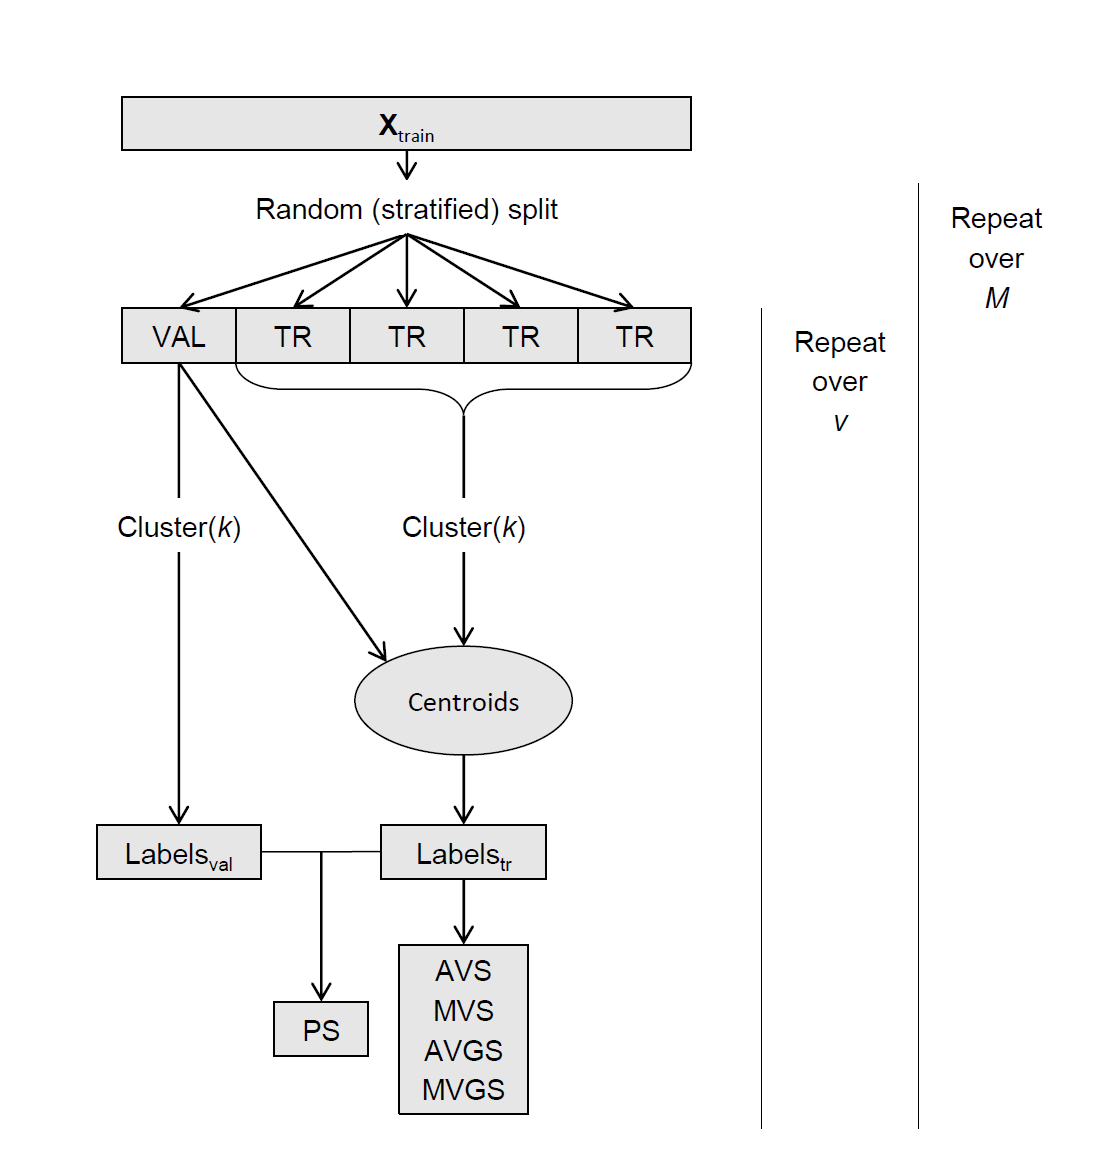

Since we will work with HDBSCAN, we cannot use the Silhouette score as a performance metric since it is not suited for density based clustering algorithms, we will thus use the **Cluster Density Based Validation (CDBV) index** implemented by the HDBSCAN module as **our main performance indicator**. This will allow us to select the algorithm and hyperparameters providing the clusters with the highest density to select the best possible customer segmentation as required by the business need.

We will also compute **Prediction Strength** with a manual implementation inspired from the fpc R package in order to assess the **stability of the clusters**. 

We will then look at the **shapes of both models** after hyperparameter tuning **using Principal Component Analysis (PCA).**

### 4.1 Defining Predictive Strength

In [ ]:
#Defining the predictive strength, extracted from 
#https://towardsdatascience.com/prediction-strength-a-simple-yet-relatively-unknown-way-to-evaluate-clustering-2e5eaf56643


def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid


def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

### 4.2 Kmeans Hyperparameter Tuning

In [60]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from hdbscan.validity import validity_index

scores = []
kf = StratifiedKFold(n_splits=5)

for train_index, test_index in kf.split(X_train_tr):
    X_train = X_train_tr[train_index]
    X_test = X_train_tr[test_index]
    
    for k in range (2,12):  #Higher values of K have been tested before implementation of PS and have lower performance
        
        km_tr = KMeans(n_clusters=k, random_state=10, n_init = 10).fit(X_train)
        km_tst = KMeans(n_clusters=k, random_state=10, n_init = 10).fit(X_test)
        cluster_labels = km_tr.labels_
        ssd = km_tr.inertia_
        sil = silhouette_score(X_train, cluster_labels)
        val = validity_index(X_train, cluster_labels)
        pred_str = get_prediction_strength(k, km_tr.cluster_centers_, X_test, km_tst.labels_)
        print("K: {}, Silhouette: {}, Validity: {}, Prediction Strength: {}".format(k, sil, val, pred_str))
        scores.append({'K': k, 'SSD': ssd, 'Silhouette': sil, 'Validity': val, 'Prediction Strength': pred_str})
    

scores = pd.DataFrame(scores).groupby("K").mean().reset_index()
    



2
3
4
5
6
7
8
9
10
11
12
13
14
15
2
3
4
5
6
7
8
9
10
11
12
13
14
15
2
3
4
5
6
7
8
9
10
11
12
13
14
15


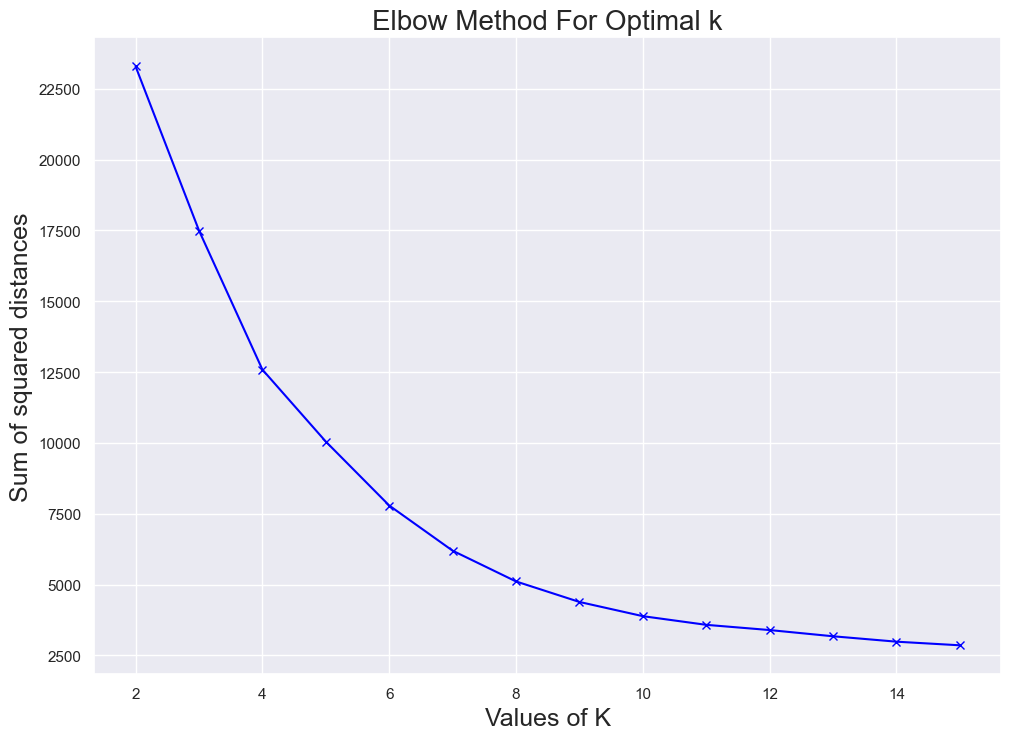

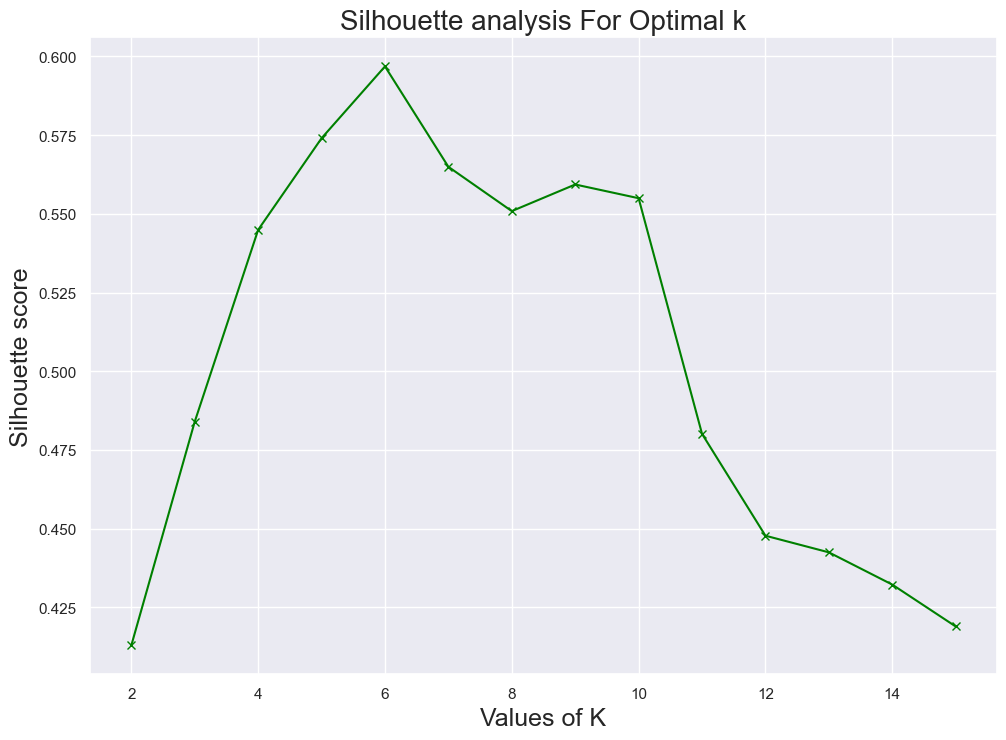

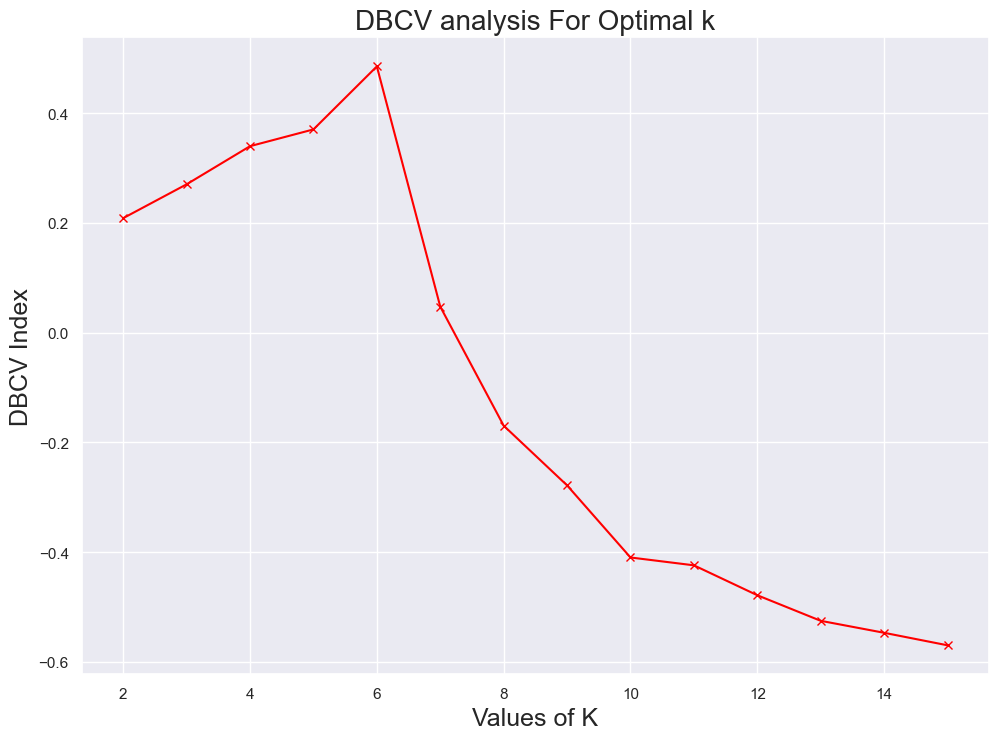

In [61]:
#Importing MaxNLocator to restrict matplotlib scale to integers
from matplotlib.ticker import MaxNLocator

#Plotting our Elbow Score
ax = plt.figure().gca()
plt.plot(scores.K, scores.SSD,'x-', color="blue", label = "SSD")
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Displaying the Silhouette score
ax = plt.figure().gca()
plt.plot(scores.K,scores.Silhouette,'x-', color="green", label="Silhouette score" )
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Displaying the HDBSCAN Validity Index (DBCV)
ax = plt.figure().gca()
plt.plot(scores.K,scores.Validity,'x-', color="orange", label="DBCV Index" )
plt.xlabel('Values of K') 
plt.ylabel('DBCV Index') 
plt.title('DBCV analysis For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Displaying the Predictive Strength
ax = plt.figure().gca()
plt.plot(scores.K,scores["Predictive Strength"],'x-', color="red", label="Predictive Strength" )
plt.xlabel('Values of K') 
plt.ylabel('Predictive Strength') 
plt.title('Predictive Strength analysis For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

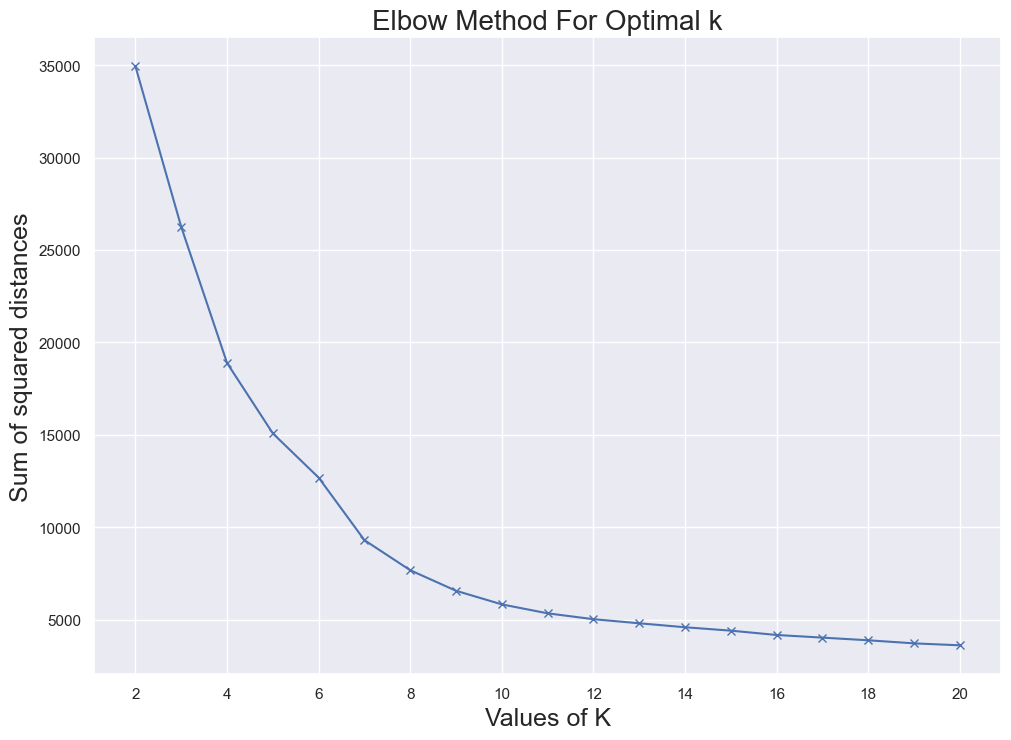

C:\Users\fatsk\AppData\Local\Temp\ipykernel_2056\1721791861.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(scores.K, scores.CHS,'bx-', color="red", label="CH score")


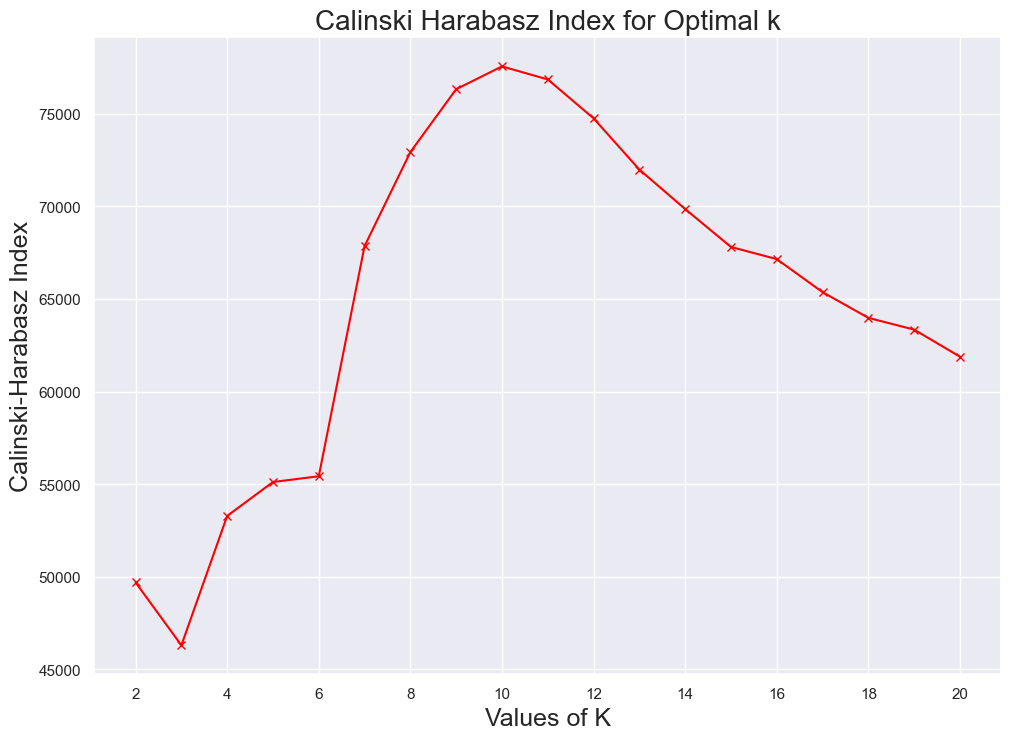

C:\Users\fatsk\AppData\Local\Temp\ipykernel_2056\1721791861.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(scores.K,scores.Silhouette,'bx-', color="green", label="Silhouette score" )


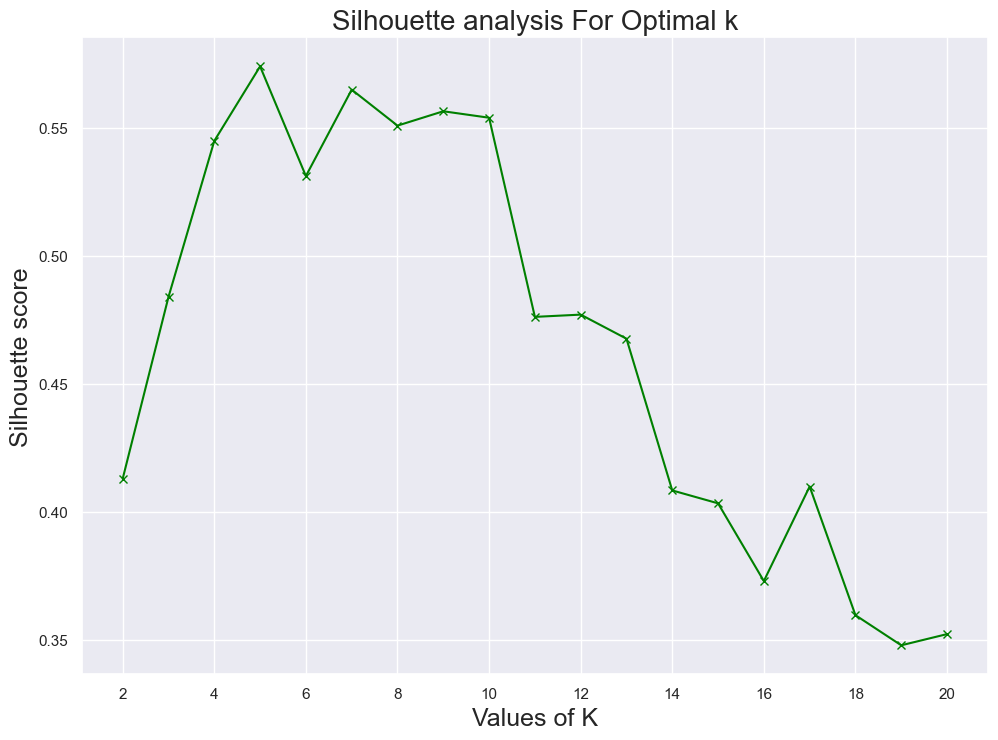

In [102]:
from matplotlib.ticker import MaxNLocator

#Plotting our Elbow Score
ax = plt.figure().gca()
plt.plot(scores.K, scores.SSD,'x-', color="blue", label = "SSD")
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Displaying the Silhouette score
ax = plt.figure().gca()
plt.plot(scores.K,scores.Silhouette,'x-', color="green", label="Silhouette score" )
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

#Displaying the HDBSCAN Validity Index (DBCV)
ax = plt.figure().gca()
plt.plot(scores.K,scores.Validity,'x-', color="red", label="DBCV Index" )
plt.xlabel('Values of K') 
plt.ylabel('DBCV Index') 
plt.title('DBCV analysis For Optimal k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [66]:
#Selecting 5 as our best amount of clusters
km = KMeans(n_clusters=6)
clusters= km.fit_predict(X_train_tr)

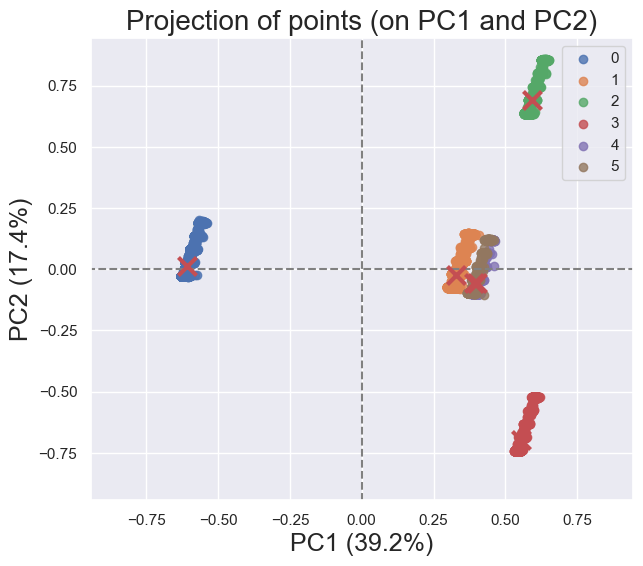

In [67]:
from sklearn.decomposition import PCA
from functions import *

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(X_train_tr)

# Transfor the scaled data to the new PCA space
X_train_red = pca.transform(X_train_tr)

centres_reduced = pca.transform(km.cluster_centers_)

display_factorial_planes(X_train_red, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)
plt.show()

### 4.3 HDBSCAN Hyperparameter Tuning

In [ ]:
#We see that clusters are not spherical, let's try the HDBSCAN algorithm 
import hdbscan
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score
from hdbscan.validity import validity_index

hdb = hdbscan.HDBSCAN(gen_min_span_tree=True)

# specify parameters and distributions to sample from
param_grid = list(ParameterGrid(
    {
    'min_samples': [10,100,300,500,1000],
    'min_cluster_size': [100,1000,3000,5000,10000],
    'cluster_selection_method': ['eom','leaf'],
    'metric': ['euclidean','manhattan']
}))

scores = []
i = 0
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X_train_tr):
    X_train = X_train_tr[train_index]
    X_test = X_train_tr[test_index]
    #Performing manual gridsearch
    for params in param_grid:
        print(i)
        i+=1
        hdb = hdbscan.HDBSCAN(prediction_data=True,
                              gen_min_span_tree=True,
                              core_dist_n_jobs=-1,
                              min_samples=params['min_samples'],
                              min_cluster_size=params['min_cluster_size'],
                              cluster_selection_method=params['cluster_selection_method'],
                              metric=params['metric']).fit(X_train)
        
        cluster_labels = hdbscan.approximate_predict(hdb,X_test)[0]
        #sil = silhouette_score(X_test, cluster_labels)
        val = validity_index(X_test, cluster_labels)
        val_train = hdb.relative_validity_
    
        scores.append({'min_samples': params['min_samples'],
                       'min_cluster_size': params['min_cluster_size'],
                       'cluster_selection_method': params['cluster_selection_method'],
                       'metric': params['metric'],
                       #'Silhouette': sil,
                       'Validity Test': val,
                       'Validity Train': val_train})

scores_df = pd.DataFrame(scores).groupby(
    ["min_samples",'min_cluster_size','cluster_selection_method','metric']).mean().reset_index()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [51]:
#Saving our scores dataframe
import dill
with open('Data/hdbscan_scores.pkl', 'wb') as file:
    dill.dump(scores_df,file)

{'cluster_selection_method': 'eom',
 'metric': 'euclidean',
 'min_cluster_size': 20000,
 'min_samples': 10}

## 5. Final Model Analysis

### 5.1 Model Performance

### 5.2 Model Shape

### 5.3 Describing the characteristic of our clusters